# Exercise 3 - part A: Reporting results of eQTL analysis
### Chosen datasets: ```Blood stem cell (GSE18067)```, ```Erythroid (GSE18067)```
### Chosen phenotype: `Infectious disease, immune function: H5N1 influenza A virus mortality rate 30 days after infection (Boon-Webby Trait 1) [% death]`

#### Written by: Shani Soustiel, id 316315720 and Shir Tova Segev, id 207353822

Importing the necessary libraries

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import false_discovery_control as fdr
import pickle

CELL_TYPE = "Erythroid"  # Erythroid, Stem

load the data from pickle

In [24]:
with open(f"./data/association_{CELL_TYPE}.pkl", "rb") as f:
    data_res = pickle.load(f)   # association results
    genes_loc = pickle.load(f)  # gene locations
    snps_loc = pickle.load(f)   # snp locations

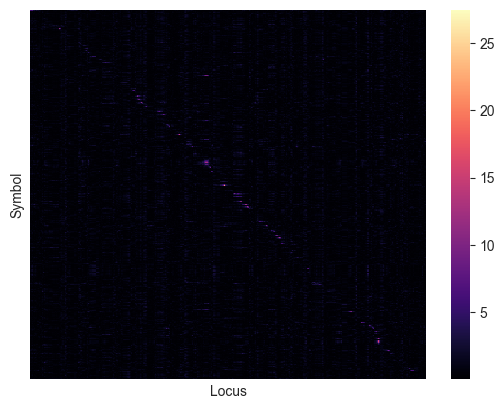

In [25]:
sns.heatmap(-np.log10(data_res), xticklabels=False, yticklabels=False, cmap='magma')
plt.show()

Apply FDR correction

In [26]:
# flatten the data for FDR correction
data_fdr = fdr(data_res.values.flatten())

# reshape the corrected data back to the original shape
data_fdr = data_fdr.reshape(data_res.shape)
data_fdr = pd.DataFrame(data_fdr, index=data_res.index, columns=data_res.columns)

find significant coordinates

In [27]:
# Find significant coordinates using vectorized operations
significant_indices = np.argwhere(data_fdr < 0.05)

# Create a DataFrame with the significant coordinates
data_eqtls = pd.DataFrame({
    "gene_name": data_fdr.index[significant_indices[:, 0]],
    "gene_loc": genes_loc[significant_indices[:, 0]],
    "snp_name": data_fdr.columns[significant_indices[:, 1]],
    "snp_loc": snps_loc[significant_indices[:, 1]],
    "p-value": data_fdr.values[significant_indices[:, 0], significant_indices[:, 1]]
})

Q1: How many eQTLs are cis and trans?

In [28]:
CIS_THRESHOLD = 2e6
data_eqtls["distance"] = np.abs(data_eqtls["gene_loc"] - data_eqtls["snp_loc"])
data_eqtls["type"] = np.where(data_eqtls["distance"] <= CIS_THRESHOLD, "cis", "trans") # equal or less than 2e6 is cis

# Print the number of cis and trans eQTLs
print(f"Number of cis eQTLs: {len(data_eqtls[data_eqtls['type'] == 'cis'])}")
print(f"Number of trans eQTLs: {len(data_eqtls[data_eqtls['type'] == 'trans'])}")

Number of cis eQTLs: 990
Number of trans eQTLs: 2448


Q2: Distribution of genes associated with eQTL

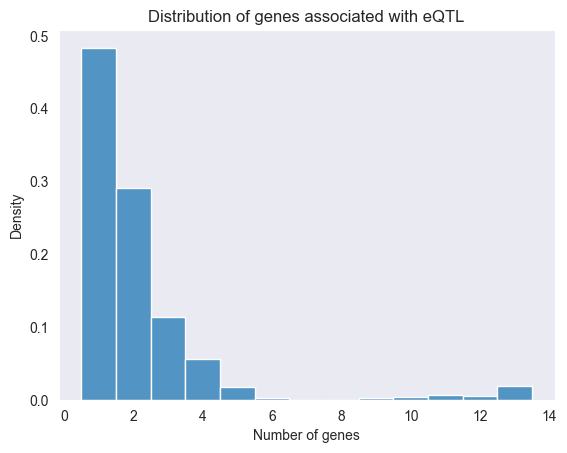

In [29]:
sns.histplot(data_eqtls["snp_name"].value_counts(), stat="density", bins=20, discrete=True)
plt.xlabel("Number of genes")
plt.ylabel("Density")
plt.title("Distribution of genes associated with eQTL")
plt.grid()
plt.show()

Q3: number of eQTLs for each SNP

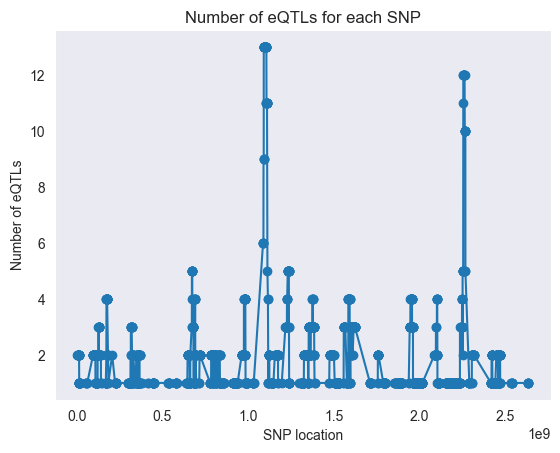

In [30]:
# Group by SNP and count the number of eQTLs for each SNP
snp_eqtl_counts = data_eqtls.groupby('snp_loc').size().reset_index(name='eqtl_count')

# Plot the number of eQTLs for each SNP
plt.plot(snp_eqtl_counts['snp_loc'], snp_eqtl_counts['eqtl_count'], '-o')
plt.xlabel('SNP location')
plt.ylabel('Number of eQTLs')
plt.title('Number of eQTLs for each SNP')
plt.grid()
plt.show()

Q4: Distribution of p-values for cis and trans eQTLs

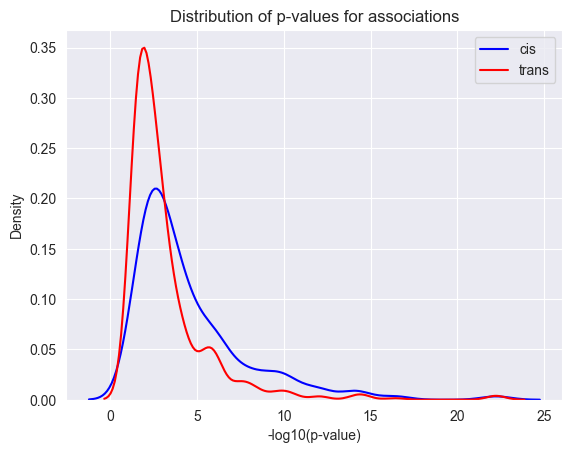

In [31]:
# Separate the p-values into cis and
cis_p_values = data_eqtls[data_eqtls['type'] == 'cis']['p-value']
trans_p_values = data_eqtls[data_eqtls['type'] == 'trans']['p-value']

# Plot the distribution of p-values for cis eQTLs
sns.kdeplot(-np.log10(cis_p_values), color='blue', label='cis')
sns.kdeplot(-np.log10(trans_p_values), color='red', label='trans')

plt.xlabel('-log10(p-value)')
plt.ylabel('Density')
plt.title('Distribution of p-values for associations')
plt.legend()
plt.show()

Q5: Scatter plot of all associations

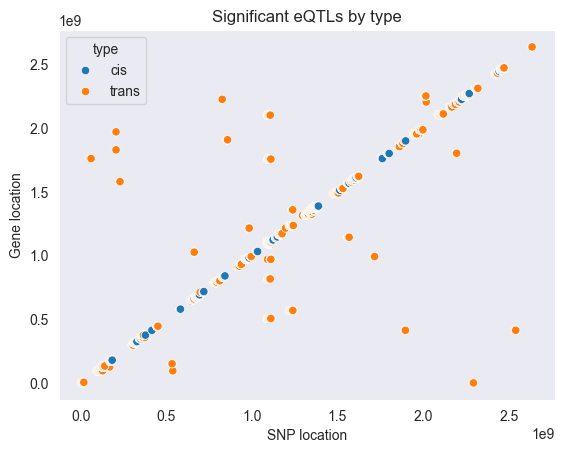

In [32]:
sns.scatterplot(data=data_eqtls, x="snp_loc", y="gene_loc", hue="type")
plt.xlabel("SNP location")
plt.ylabel("Gene location")
plt.title("Significant eQTLs by type")
plt.grid()
plt.show()

save data

In [33]:
with open(f"./data/analysis_{CELL_TYPE}.pkl", "wb") as f:
    pickle.dump(data_eqtls, f)